In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm

def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.reshape(image.astype(np.float32).ravel(), [80,80])

class Policy(nn.Module):
    def __init__(self, output_dim):
        super(Policy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(80 * 80, 512),  # Input is flattened 80x80 image
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

def policy_gradient(env_name, num_episodes, gamma, alpha):
    env = gym.make(env_name, render_mode="rgb_array")
    output_dim = env.action_space.n
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy = Policy(output_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=alpha)
    
    episode_r = []
    moving_avg_r = []
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        state, _ = env.reset()
        state = preprocess(state)  # Preprocess the initial state
        log_action_probs = []
        rewards = []
        done = False
        
        while not done:
            # Reshape state to (1, 6400) - (batch_size, flattened_image)
            state_tensor = torch.FloatTensor(state.ravel()).unsqueeze(0).to(device)
            action_probs = policy(state_tensor)
            
            # sample action
            action = Categorical(action_probs).sample()
            
            # next 
            next_state, r, terminated, truncated, _ = env.step(action.item())
            next_state = preprocess(next_state)  # Preprocess the next state
            
            # store log prob and reward
            log_action_probs.append(Categorical(action_probs).log_prob(action))
            rewards.append(r)
            
            # update 
            state = next_state
            done = terminated or truncated
        
        episode_r.append(sum(rewards))
        
        # moving avg
        if len(episode_r) >= 100:
            moving_avg_r.append(np.mean(episode_r[-100:]))
            
        # discount
        R = 0
        discount_r = []
        for r in reversed(rewards):
            R = r + gamma*R
            discount_r.insert(0, R)
        discount_r = torch.FloatTensor(discount_r).to(device)
        discount_r = (discount_r - discount_r.mean()) / (discount_r.std() + 1e-8)
        
        # loss func
        loss = []
        for log_prob, R in zip(log_action_probs, discount_r):
            loss.append(-log_prob * R)
        loss = torch.stack(loss).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (episode + 1) % 100 == 0:
            tqdm.write(f"Episode {episode + 1} Average Reward: {np.mean(episode_r[-100:])}")
    
    return policy, episode_r, moving_avg_r

# Example usage
env_name = 'ALE/Pong-v5'
num_episodes = 1000
discount_factor = 0.95
learning_rate = 0.001

trained_policy, episode_rewards, moving_avg_rewards = policy_gradient(env_name, num_episodes, gamma=discount_factor, alpha=learning_rate)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]/nfs/home/zri6387/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Training:  10%|█         | 100/1000 [04:31<58:51,  3.92s/it]

Episode 100 Average Reward: -19.62


Training:  20%|██        | 200/1000 [12:50<1:11:55,  5.39s/it]

Episode 200 Average Reward: -18.52


Training:  30%|███       | 300/1000 [22:20<48:21,  4.14s/it]  

Episode 300 Average Reward: -16.59


Training:  40%|████      | 400/1000 [30:01<49:59,  5.00s/it]

Episode 400 Average Reward: -13.76


Training:  50%|█████     | 500/1000 [38:28<44:45,  5.37s/it]

Episode 500 Average Reward: -12.42


Training:  60%|██████    | 600/1000 [47:29<39:24,  5.91s/it]

Episode 600 Average Reward: -10.75


Training:  70%|███████   | 700/1000 [56:44<28:58,  5.79s/it]

Episode 700 Average Reward: -10.42


Training:  80%|████████  | 800/1000 [1:05:53<17:45,  5.33s/it]

Episode 800 Average Reward: -10.69


Training:  90%|█████████ | 900/1000 [1:14:34<08:23,  5.04s/it]

Episode 900 Average Reward: -11.87


Training: 100%|██████████| 1000/1000 [1:22:43<00:00,  4.96s/it]

Episode 1000 Average Reward: -14.27


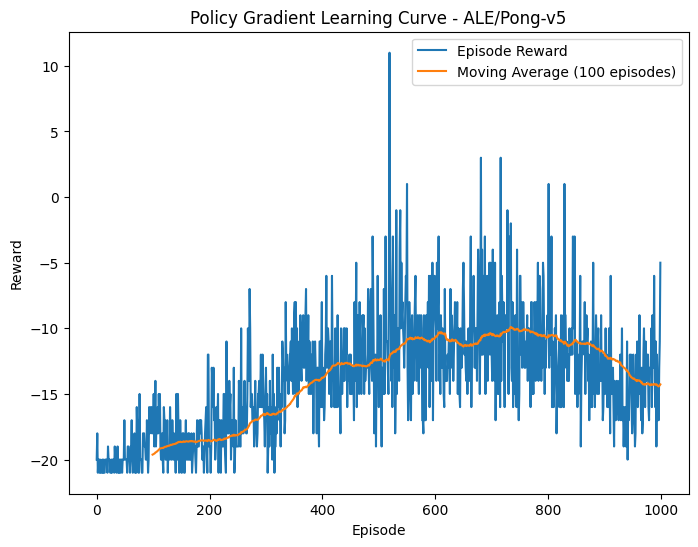

In [7]:
# plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(range(99, len(episode_rewards)), moving_avg_rewards, label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Policy Gradient Learning Curve - {env_name}')
plt.legend()
plt.show()

In [11]:
def rollout(enc, policy, num_episodes = 500):
    episode_r = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            # trajectory 
            state_tensor = torch.FloatTensor(state.ravel()).unsqueeze(0).to(device)
            action_probs = policy(state_tensor)
            action = torch.argmax(action_probs)
            # next 
            next_state, r, terminated, truncated, _ = env.step(action.item())
            
            # store reward
            total_reward += r
            
            # update 
            state = next_state
            done = terminated or truncated
        
        episode_r.append(total_reward)
        
    return episode_r

In [12]:
# on GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
print(device)
env = gym.make(env_name, render_mode="rgb_array")
rollout_rewards = rollout(env, trained_policy)

print(f'Mean Reward: {np.mean(rollout_rewards)}')
print(f'Standard Deviation: {np.std(rollout_rewards)}')

cuda


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100800 and 6400x512)